In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization, Input, GlobalAveragePooling2D, Dropout, Dense, concatenate
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from sklearn import svm


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/40x/Train/Benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/40x/Train/Malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/40x/Test/Benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/40x/Test/Malignant',224))

100%|██████████| 284/284 [01:06<00:00,  4.29it/s]


# Create Label

In [ ]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

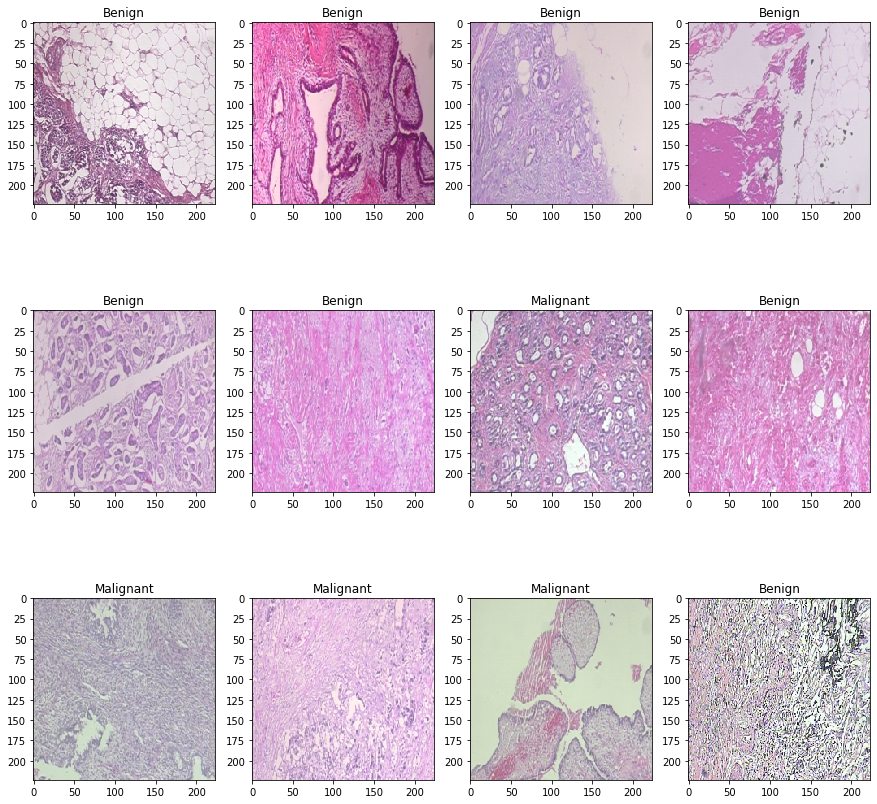

In [ ]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
from tensorflow.python.keras import applications
from keras.applications import DenseNet169, DenseNet121, VGG19, ResNet152, Xception

# Model: Grand Parallel Model

In [8]:
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.python.keras import applications
from keras.applications import DenseNet169, DenseNet121, VGG19, ResNet152, Xception, inception_v3
def build_model(lr=1e-4):
    model_Input = Input(shape = (224,224,3))

    ###### DenseNet201 Model ######
    dense_model = DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3))(model_Input)
    dense_model_globalavg = GlobalAveragePooling2D()(dense_model)
    dense_model_Dropout = Dropout(0.5)(dense_model_globalavg)
    dense_model_BatchNormalization = BatchNormalization()(dense_model_Dropout)
    #######################

    ###### ResNet152 Model ######
    res_model = ResNet152(weights='imagenet',include_top=False,input_shape=(224,224,3))(model_Input)
    res_model_globalavg = GlobalAveragePooling2D()(res_model)
    res_model_Dropout = Dropout(0.5)(res_model_globalavg)
    res_model_BatchNormalization = BatchNormalization()(res_model_Dropout)
    #######################
    
    ###### VGG19 Model ######
    vgg_model = VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))(model_Input)
    vgg_model_globalavg = GlobalAveragePooling2D()(vgg_model)
    vgg_model_Dropout = Dropout(0.5)(vgg_model_globalavg)
    vgg_model_BatchNormalization = BatchNormalization()(vgg_model_Dropout)
    #######################
    
    ###### Xception Model ######
    Xception_model = Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))(model_Input)
    Xception_model_globalavg = GlobalAveragePooling2D()(Xception_model)
    Xception_model_Dropout = Dropout(0.5)(Xception_model_globalavg)
    Xception_model_BatchNormalization = BatchNormalization()(Xception_model_Dropout)
    #######################
    
    ###### Inception_v3 Model ######
    Inception_v3_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))(model_Input)
    Inception_v3_model_globalavg = GlobalAveragePooling2D()(Inception_v3_model)
    Inception_v3_model_Dropout = Dropout(0.5)(Inception_v3_model_globalavg)
    Inception_v3_model_BatchNormalization = BatchNormalization()(Inception_v3_model_Dropout)
    #######################

    model_concat = concatenate([dense_model_BatchNormalization, res_model_BatchNormalization, vgg_model_BatchNormalization, Xception_model_BatchNormalization, Inception_v3_model_BatchNormalization])
    
    model_Dense_1 = Dense(1000)(model_concat)
    model_Drop_1 = Dropout(0.5)(model_Dense_1)
    model_Dense_2 = Dense(1000)(model_Drop_1)
    model_Drop_2 = Dropout(0.5)(model_Dense_2)
    model_Output = Dense(2,activation='softmax')(model_Drop_2)
    
    model = Model(inputs=model_Input, outputs=model_Output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [9]:
#@title Default title text
K.clear_session()
gc.collect()

model = build_model(lr = 1e-4)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 7, 7, 1920)   18321984    input_1[0][0]                    
__________________________________________________________________________________________________
resnet152 (Functional)          (None, 7, 7, 2048)   58370944    input_1[0][0]                    
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_1[0][0]                    
_____________________________

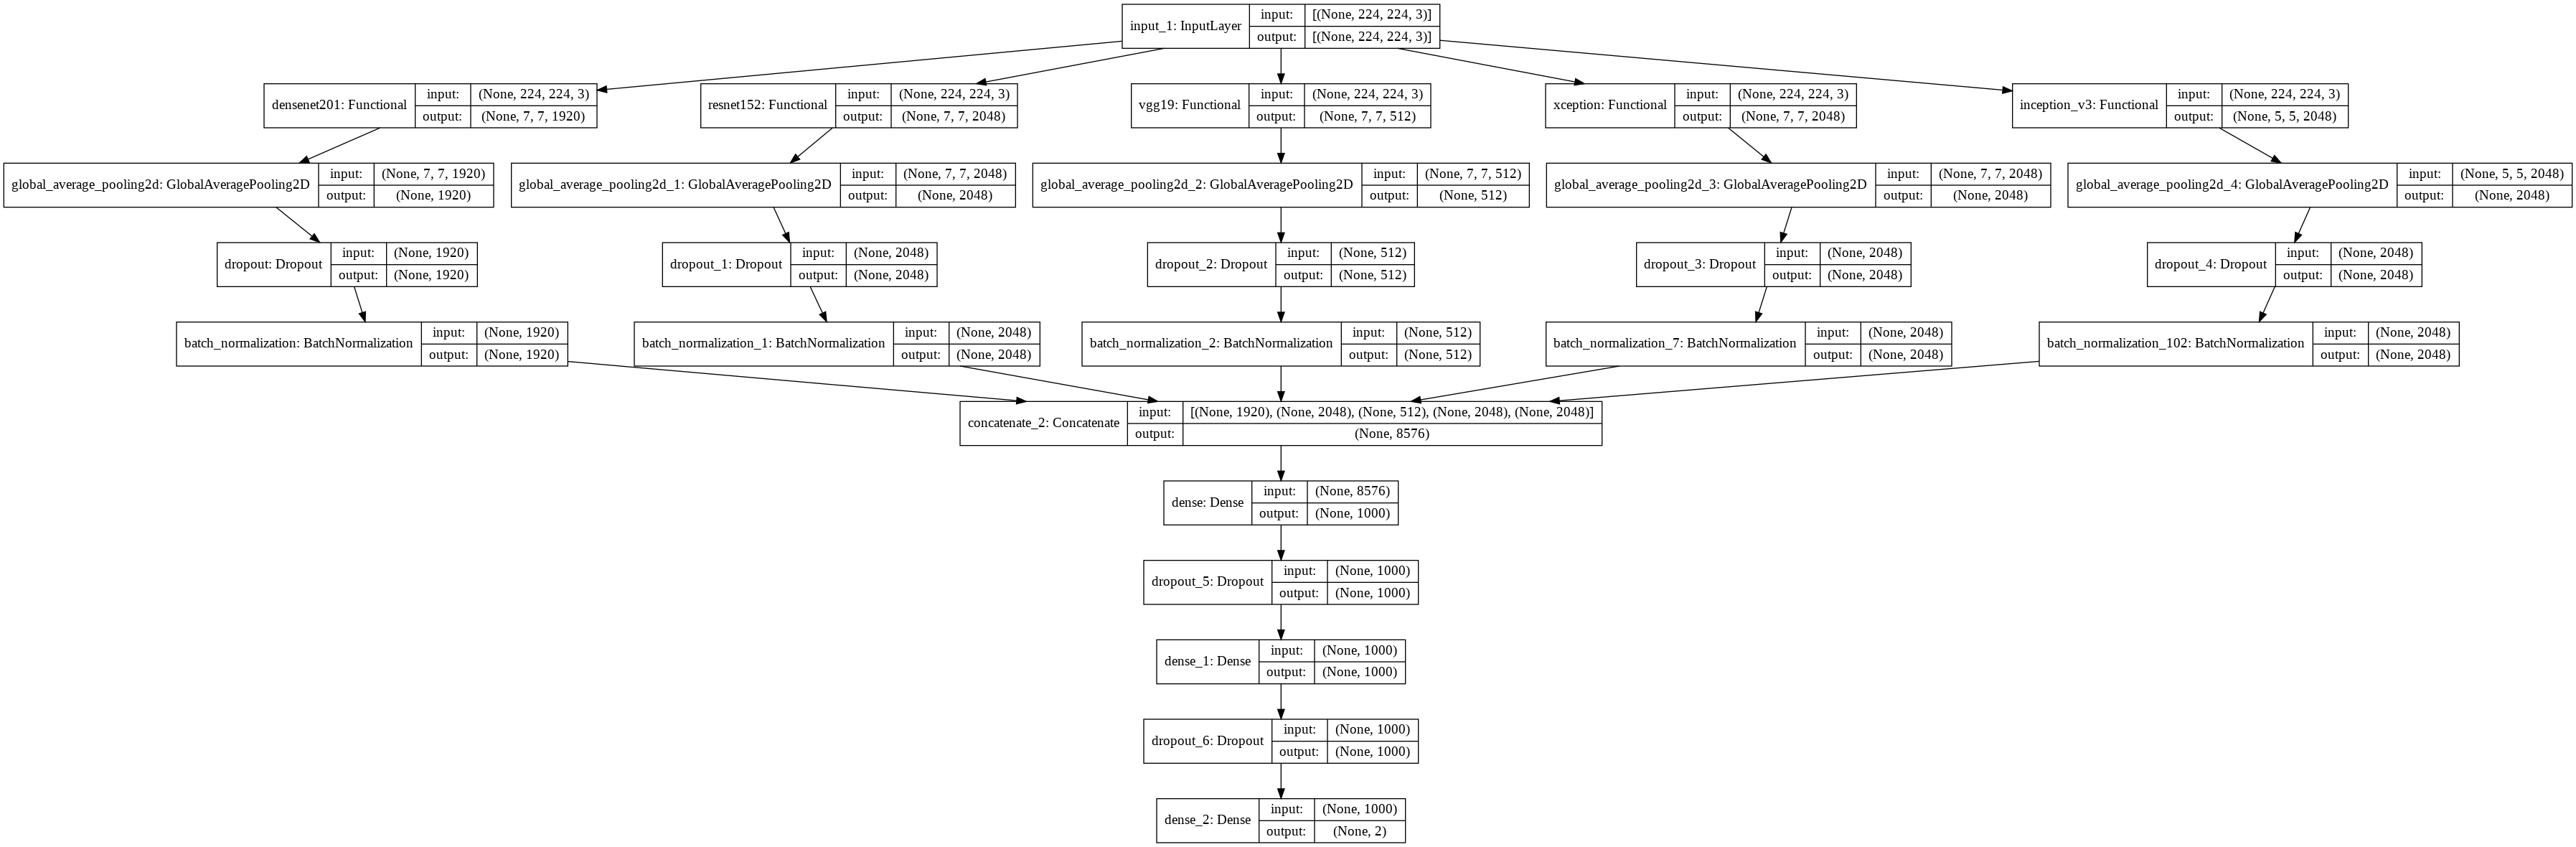

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


In [ ]:
while True:pass

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy','val_accuracy']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.save_weights("Parallel_model_100_Epochs.hdf5")

# Prediction

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.9645345155161494

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    print('Confusion matrix, for Kaggle BHI')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')